In [2]:
#Install Dataset and import requirements
!pip install -q gdown
import gdown
import zipfile
import os
import gradio

file_id = "1BYLz8QCTjIvGTW3b-g0okooNZLJd4ykz"
url = f"https://drive.google.com/uc?id={file_id}"

output = "e-waste-dataset.zip"
folder = "e-waste-dataset"

if not os.path.exists(folder):
    print("Downloading dataset")
    gdown.download(url, output, quiet=False)

    print("Unzipping dataset")
    with zipfile.ZipFile(output, "r") as zip_ref:
        zip_ref.extractall(".")
    os.remove(output)
    print("Dataset ready!")
else:
    print("Dataset already exists.")


Downloading...
From: https://drive.google.com/uc?id=1BYLz8QCTjIvGTW3b-g0okooNZLJd4ykz
To: /content/e-waste-dataset.zip
100%|██████████| 12.4M/12.4M [00:00<00:00, 33.1MB/s]


Unzipping dataset
Dataset ready!


In [3]:
!pip install tensorflow

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr
from PIL import Image
import time

In [5]:
base_dir = "modified-dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


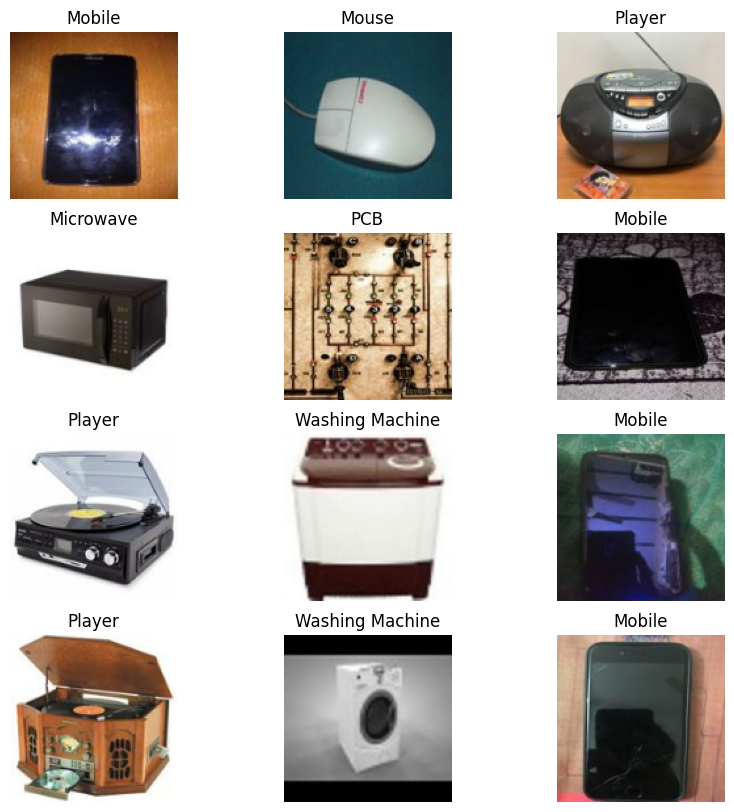

In [6]:
#EDA and Data Augmentation
datatrain= tf.keras.utils.image_dataset_from_directory(train_dir, shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)
datavalid = tf.keras.utils.image_dataset_from_directory(val_dir,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)
datatest=tf.keras.utils.image_dataset_from_directory(test_dir,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [7]:
#Model Selection and Training
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape = (128, 128, 3),
    include_top = False,
    weights = 'imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = 'softmax')
])
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['Accuracy'])

#callback to stop training if validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

#Training
epochs = 15
start_time = time.time()
history = model.fit(
    datatrain,
    validation_data = datavalid,
    epochs = epochs,
    batch_size = 100,
    callbacks = [early]
)
end_time = time.time()
print(f"Training completed in {end_time - start_time} seconds")

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 152ms/step - Accuracy: 0.2539 - loss: 2.1717 - val_Accuracy: 0.7667 - val_loss: 1.1532
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - Accuracy: 0.7792 - loss: 1.0228 - val_Accuracy: 0.9033 - val_loss: 0.4878
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - Accuracy: 0.8552 - loss: 0.5530 - val_Accuracy: 0.9433 - val_loss: 0.2872
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - Accuracy: 0.9055 - loss: 0.3427 - val_Accuracy: 0.9400 - val_loss: 0.2304
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - Accuracy: 0.9272 - loss: 0.2376 - val_Accuracy: 0.9567 - val_loss: 0.1842
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - Accuracy: 0.9502 - loss: 0.1856 - val_Accuracy: 0.9533 - val_loss: 0.1721
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - Accuracy: 0.9628 - loss: 0.1383 - val_Accuracy: 0.9600 - val_loss: 0.1613
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - Ac

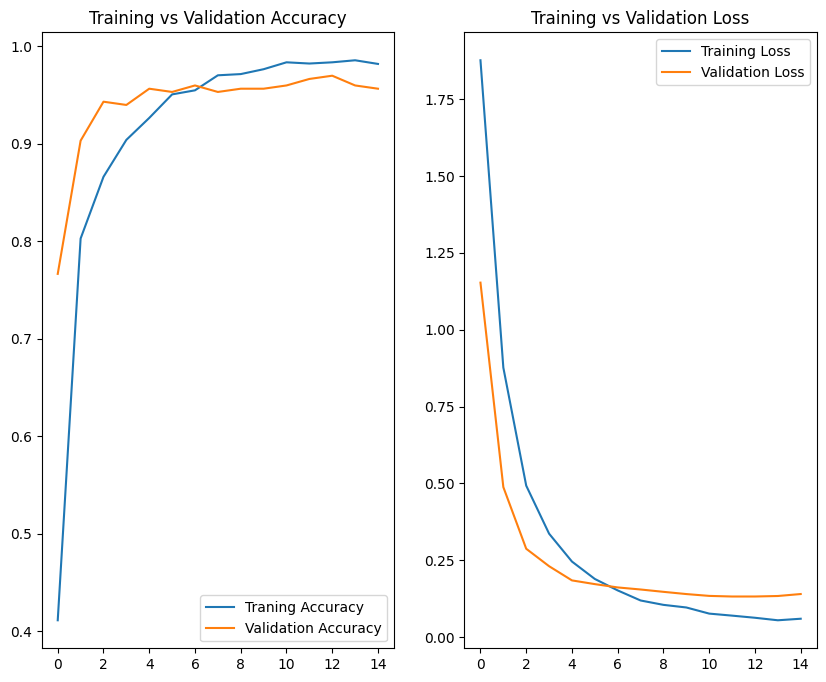

In [8]:
#Model Performance Metrics
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Traning Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training vs Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()

In [9]:
#Testing Model on Testing Dataset
test_loss, test_accuracy = model.evaluate(datatest)
print(f"Test accuracy is {test_accuracy}\nTest loss is {test_loss}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Accuracy: 0.9442 - loss: 0.1544
Test accuracy is 0.95333331823349
Test loss is 0.12868674099445343


In [10]:
y_true = np.concatenate([y.numpy() for x, y in datatest], axis = 0)
y_pred_probs = model.predict(datatest)
y_pred = np.argmax(y_pred_probs, axis = 1)
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step
[[27  0  0  0  0  2  1  0  0  0]
 [ 1 29  0  0  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  1  1  0  0]
 [ 0  0  0 29  0  1  0  0  0  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  1  0 29  0  0]
 [ 0  0  2  1  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0  1  0 29]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        30
           1       1.00      0.97      0.98        30
           2       0.93      0.93      0.93        30
           3       0.97      0.97      0.97        30
           4       1.00      0.97      0.98        30
           5       0.88      0.97      0.92        30
           6       0.91      1.00      0.95        30
           7       0.91      0.97      0.94        30
           8       1.00      0.90      0.95        30
           9       1.00      0.97      0.98        30

    accuracy                    

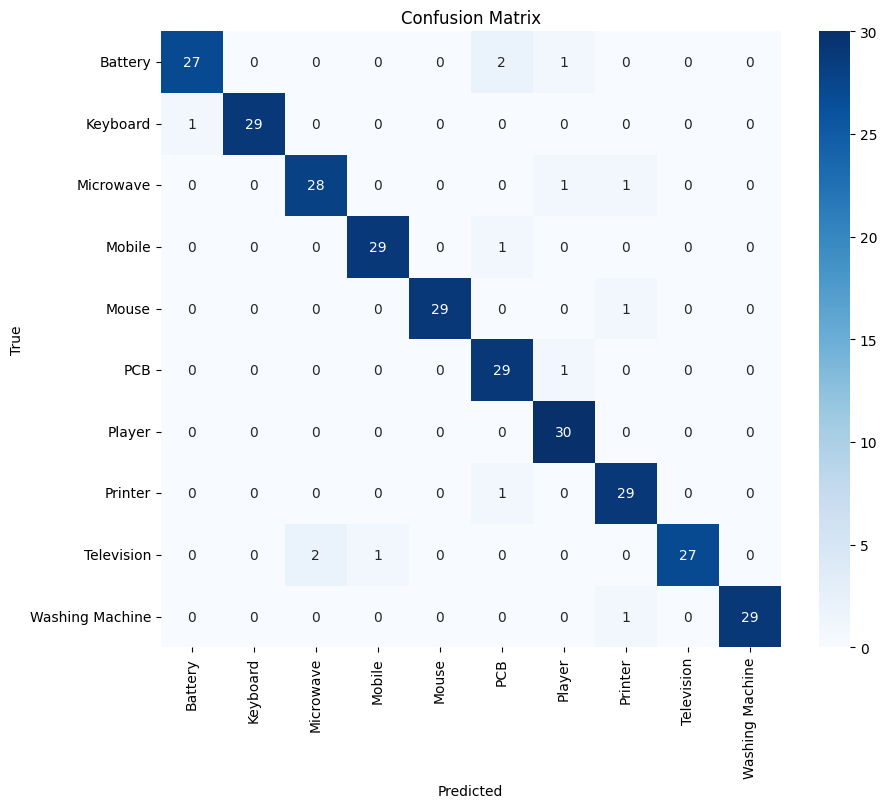

In [11]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize =  (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Found 14 misclassified images.


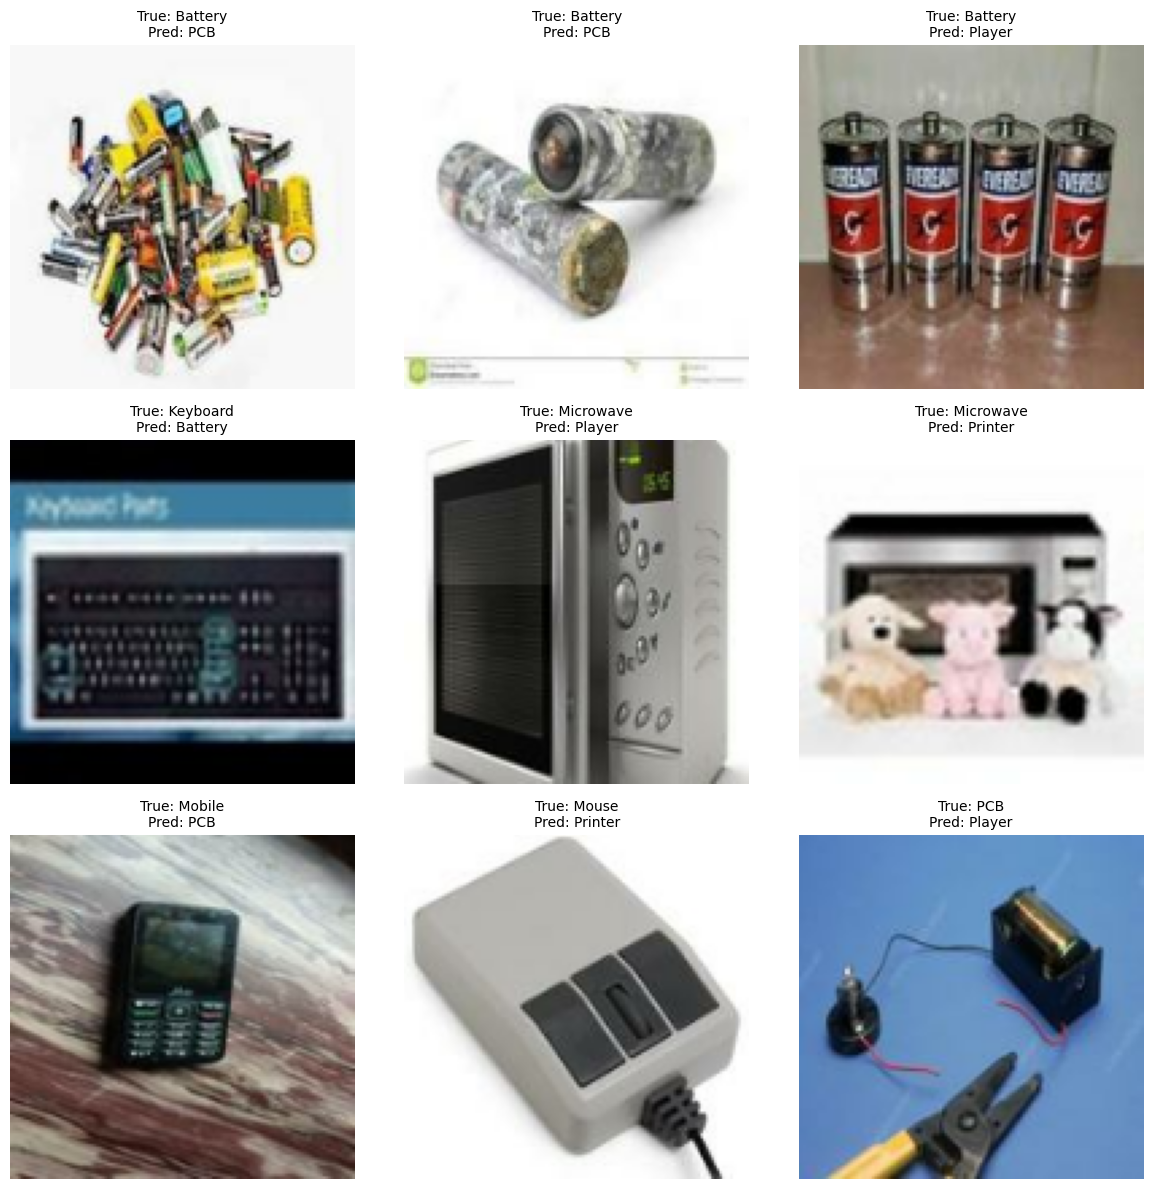

In [12]:
def show_misclassified_images_dataset(model, dataset, class_names, max_images=9):
    """
    Visualize misclassified images from a tf.data.Dataset.

    Args:
        model: Trained Keras model
        dataset: tf.data.Dataset yielding (x, y) pairs
        class_names: List of class labels (strings)
        max_images: Max number of misclassified images to show
    """
    y_true = []
    y_pred = []
    images = []

    for x_batch, y_batch in dataset:
        preds = model.predict(x_batch, verbose=0)
        y_true.extend(y_batch.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
        images.extend(x_batch.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    images = np.array(images)

    # Find misclassified indices
    misclassified_idx = np.where(y_true != y_pred)[0]

    print(f"Found {len(misclassified_idx)} misclassified images.")

    # Plot
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(misclassified_idx[:max_images]):
        plt.subplot(int(np.sqrt(max_images)), int(np.sqrt(max_images)), i+1)
        plt.imshow(images[idx].astype("uint8"))
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_misclassified_images_dataset(model, datatest, class_names, max_images=9)

In [13]:
model.save('e_waste_classify.keras')

In [14]:
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

model = tf.keras.models.load_model('e_waste_classify.keras')

In [15]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

# Create a Gradio interface for the classify_image function
ui = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)

# Launch the Gradio interface, opening a local web app to interact with the model
ui.launch(share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e0919710df8ccba275.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
